In [2]:
import pickle
from phystables import BasicTable, SimpleTable, make_noisy
from phystables.constants import *
import define_tables
from define_tables import WallData, GoalData, BallData, TableData
import pygame as pg
import argparse
import numpy as np
import pandas as pd
from scipy.stats import entropy
import seaborn as sns


DEF_NOISE = {
"kapv": KAPV_DEF, # VonMises precision on initial velocity angle estimation
"kapb": KAPB_DEF, # VonMises precision on the bounce angle estimation
"kapm": KAPM_DEF, # VonMises precision on the motion jitter
"perr": PERR_DEF  # Gaussian error on initial position estimation
}

def _ballhit(balllist):
    blcol = list(map(lambda b: b.col, balllist))
    print("Observed ball collisions: ", blcol)

def _goalhit(ball, goal):
    gtype = get_const(goal.ret)
    print("Ball", ball.col, "hit goal", gtype)

        
def getTable(tables_file, table_id, purpleBall, goldBall, noisy, callback=False, printTable=False):
    '''
    tables_file: File name with tables
    table_id: Table from table_files
    trial_id: Determines which simulation to run 
    noisy: T/F
    callback: T/F
    '''
    with open(tables_file, 'rb') as input:
        tablesData = pickle.load(input)
    tableData = tablesData[table_id]
    

            
    
    table = BasicTable(dims=tableData.dims)
    if printTable:
        print('\nWall Data:')
    for i, wall in enumerate(tableData.walls):
        table.add_wall(upperleft=wall.upperleft, lowerright=wall.lowerright)
        if printTable:
            print(str(i)+ ':', 'wall.upperleft', wall.upperleft)
            print(str(i)+ ':', 'wall.lowerright', wall.lowerright)

    if printTable:
            print('\nGoal Data:')
    for i, goal in enumerate(tableData.goals):
        table.add_goal(upperleft=goal.upperleft, lowerright=goal.lowerright, onreturn=goal.onreturn, color=goal.color)
        if printTable:
            print(str(i)+ ':', 'goal.upperleft', goal.upperleft)
            print(str(i)+ ':', 'goal.lowerright', goal.lowerright)
            print(str(i)+ ':', 'goal.onreturn', goal.onreturn)
            print(str(i)+ ':', 'goal.color', goal.color)
        
    balls = tableData.balls
    if purpleBall and goldBall:
        ball_id=2
    elif purpleBall:
        ball_id=0
    elif goldBall:
        ball_id=1
    if ball_id == 0 or ball_id==1:
        table.add_ball(initpos=balls[ball_id].initpos, initvel=balls[ball_id].initvel, color=balls[ball_id].color)
        if printTable:
            print('\nBall Data:')
            print(str(ball_id)+ ':'+ ':', 'balls.color', balls[ball_id].color)
            print(str(ball_id)+ ':', 'balls.initpos',    balls[ball_id].initpos)
            print(str(ball_id)+ ':', 'balls.initvel',    balls[ball_id].initvel)
    else:
        table.add_ball(initpos=balls[0].initpos, initvel=balls[0].initvel, color=balls[0].color)
        table.add_ball(initpos=balls[1].initpos, initvel=balls[1].initvel, color=balls[1].color)
        if printTable:
            print('\nBall Data:')
            print(str(0)+ ':', 'balls.color',   balls[0].color)
            print(str(0)+ ':', 'balls.initpos', balls[0].initpos)
            print(str(0)+ ':', 'balls.initvel', balls[0].initvel)
            print(str(1)+ ':', 'balls.color',   balls[1].color)
            print(str(1)+ ':', 'balls.initpos', balls[1].initpos)
            print(str(1)+ ':', 'balls.initvel', balls[1].initvel)
        
    if noisy:
        table = make_noisy(table, **DEF_NOISE)
        
    if callback:
        table.on_ballhit = _ballhit
        table.on_goalhit = _goalhit
    
    return table

def run_to_end(trial, max_time=10.):
    while True:
        r = trial.step(t=max_time, maxtime=max_time)
        if r is not None:
            if isinstance(r, list):
                r = r[0]
            return [r, trial.tm]
    
def run_simulations(tables_file, table_id, purpleBall, goldBall, noisy, num_simulations, max_time, callback=False):    
    simulations = []
    for i in range(num_simulations):
        table = getTable(tables_file, table_id, purpleBall, goldBall, noisy, callback)
        ret, simTime = run_to_end(table, max_time)
        goalHit = get_const(ret)
        ballHit = None
        ballHit = None
        simulation = [table_id, purpleBall, goldBall, goalHit, ballHit, simTime, noisy]
        simulations.append(simulation)
    return simulations

pygame 2.0.0 (SDL 2.0.12, python 3.7.9)
Hello from the pygame community. https://www.pygame.org/contribute.html
Loading chipmunk for Darwin (64bit) [/opt/anaconda3/envs/physenv/lib/python3.7/site-packages/pymunk/libchipmunk.dylib]


In [3]:
!python define_tables.py

pygame 2.0.0 (SDL 2.0.12, python 3.7.9)
Hello from the pygame community. https://www.pygame.org/contribute.html
Loading chipmunk for Darwin (64bit) [/opt/anaconda3/envs/physenv/lib/python3.7/site-packages/pymunk/libchipmunk.dylib]


# Run Simulations and Save to Lookup Table

In [5]:
columns = ['tableID', 'purpleBall', 'goldBall', 'goalHit', 'ballHit', 'simTime', 'noisy']
LookUpTable = pd.DataFrame(columns=columns)


for ix in range(4):
    simulations = run_simulations(tables_file='tables_metadata.pkl', 
                                  table_id=ix, 
                                  purpleBall=True,
                                  goldBall=False,
                                  noisy=True, 
                                  num_simulations=5000, 
                                  max_time=10)
    LookUpTable = LookUpTable.append(pd.DataFrame(data=simulations, columns=columns), ignore_index=True)  
    print('here: 5000')

    simulations = run_simulations(tables_file='tables_metadata.pkl', 
                                  table_id=ix, 
                                  purpleBall=False,
                                  goldBall=True,
                                  noisy=True, 
                                  num_simulations=5000, 
                                  max_time=10)
    LookUpTable = LookUpTable.append(pd.DataFrame(data=simulations, columns=columns), ignore_index=True)
    print('here: 10000')

    simulations = run_simulations(tables_file='tables_metadata.pkl', 
                                  table_id=ix, 
                                  purpleBall=True,
                                  goldBall=True,
                                  noisy=True, 
                                  num_simulations=5000, 
                                  max_time=10)
    LookUpTable = LookUpTable.append(pd.DataFrame(data=simulations, columns=columns), ignore_index=True)  
    print('here: 15000')

# Save LookUpTable to file
LookUpTable.to_pickle("LookUpTable.pkl")

# Display Table Up to x columns
pd.set_option("display.max_rows", 100, "display.max_columns", 7)
LookUpTable

here: 5000
here: 10000
here: 15000
here: 5000
here: 10000
here: 15000
here: 5000
here: 10000
here: 15000
here: 5000
here: 10000
here: 15000


,tableID,purpleBall,goldBall,goalHit,ballHit,simTime,noisy
0,0,True,False,REDGOAL,None,1.626,True
1,0,True,False,REDGOAL,None,1.558,True
2,0,True,False,REDGOAL,None,7.623,True
3,0,True,False,TIMEUP,None,10.001,True
4,0,True,False,GREENGOAL,None,2.991,True
...,...,...,...,...,...,...,...
59995,3,True,True,GREENGOAL,None,1.387,True
59996,3,True,True,GREENGOAL,None,1.338,True
59997,3,True,True,REDGOAL,None,1.417,True
59998,3,True,True,GREENGOAL,None,1.357,True


In [6]:
pd.set_option("display.max_rows", 1000, "display.max_columns", 7)
LookUpTable

,tableID,purpleBall,goldBall,goalHit,ballHit,simTime,noisy
0,0,True,False,REDGOAL,None,1.626,True
1,0,True,False,REDGOAL,None,1.558,True
2,0,True,False,REDGOAL,None,7.623,True
3,0,True,False,TIMEUP,None,10.001,True
4,0,True,False,GREENGOAL,None,2.991,True
...,...,...,...,...,...,...,...
59995,3,True,True,GREENGOAL,None,1.387,True
59996,3,True,True,GREENGOAL,None,1.338,True
59997,3,True,True,REDGOAL,None,1.417,True
59998,3,True,True,GREENGOAL,None,1.357,True


# Read File, Select Values, and Turn into List

In [4]:
# Read Table In
LookUpTable = pd.read_pickle("LookUpTable.pkl")

# # Group Table and Select Group by values
# simulation_groups = unpickledLookUpTable.groupby(['tableID', 'purpleBall'])
# group_simulations = simulation_groups.get_group(name=(0,True)) # return dataframe for just tableID=0 and purpleBall=True
# # turn into a list
# group_simulations.values.tolist()
LookUpTable['simTime'].sum()/60000
LookUpTable.groupby(['tableID', 'purpleBall', 'goldBall']).get_group(name=(2,True,False))['simTime'].sum()/5000

1.417018599999987

In [56]:
################
# Small Oracle #
################

import random

def small_oracle(samples, num_sim_1, num_sim_2, iters=1000, margin=False):
    '''
    samples:        Pre-run samples to draw from, list [Ball_1, Ball_2]
    num_sim_1:      Number of simulations for ball 1
    num_sim_2:      Number of simulations for ball 2
    samples:        Number of samples (each sample has num_sim_1 + 2 sims)
    Return tuple(# green wins, # red wins, avg total time)
    # green wins:   Number of samples where #G > #R + 0.5 * ties
    # red wins:     Number of samples where #G < #R + 0.5 * ties
    avg total time: Average total time for a sample
    '''
    g_wins = 0  # track green wins
    r_wins = 0  # track red wins
    total_time = 0  # total time
    
    total_green = 0  # track Green
    total_red = 0  # track Red

    for _ in range(iters):  # get samples
        # wins for a fixed sample
        sample_g_wins = 0
        sample_r_wins = 0
        sample_time = 0
        
        # simulations for ball 1
        for sim_1 in range(num_sim_1):
            table_id,_, _, outcome, _, time, _ = random.choice(samples[0])
            if outcome == 'GREENGOAL':
                sample_g_wins += 1
            if outcome == 'REDGOAL':
                sample_r_wins += 1
            sample_time += time
        # simulations for ball 2
        for sim_2 in range(num_sim_2):
            table_id,_, _, outcome, _, time, _ = random.choice(samples[1])
            if outcome == 'GREENGOAL':
                sample_g_wins += 1
            if outcome == 'REDGOAL':
                sample_r_wins += 1
            sample_time += time
        if not margin:  # regular
            if sample_g_wins > sample_r_wins:
                g_wins += 1
            if sample_g_wins < sample_r_wins:
                r_wins += 1
            if sample_g_wins == sample_r_wins:
                g_wins += 0.5
                r_wins += 0.5
        if margin:  # keep margins
            total_green += sample_g_wins
            total_red += sample_r_wins
        total_time += sample_time
    if margin:
        if total_green + total_red == 0:
            return (0, 0, total_time/iters)
        else:
            return (total_green/(total_green+total_red), total_red/(total_green+total_red), total_time/iters)
    else:  # not margin
        return (g_wins/iters, r_wins/iters, total_time/iters)

In [52]:
def entropyReward(p,q,alpha):
    return alpha / (1 + 1000 * entropy(p,q))

def distanceReward(p,q,alpha):
    return -abs(p[0]-q[0])*alpha

def cost(time, alpha):
    return time*alpha

def big_oracle(table_id, max_simulations, LookUpTable, iters, rewardFn, costFn, alpha, beta, margin=False):
    
    utilities = []
    num_simulations = []
    # purple simulations
    
    green_truth = LookUpTable.groupby(['tableID', 'purpleBall', 'goldBall', 'goalHit']).get_group(name=(0,True, True, 'GREENGOAL')).values
    red_truth = LookUpTable.groupby(['tableID', 'purpleBall', 'goldBall', 'goalHit']).get_group(name=(0,True, True, 'REDGOAL')).values
    p = np.array([green_truth.shape[0], red_truth.shape[0]]) / np.sum([green_truth.shape[0], red_truth.shape[0]])
    
    for num_purpleBall_sims in range(max_simulations):
        if num_purpleBall_sims % 5 == 0:
            print(beta, num_purpleBall_sims)
        for num_goldBall_sims in range(max_simulations):
            purpleBall_sims = LookUpTable.groupby(['tableID', 'purpleBall', 'goldBall']).get_group(name=(table_id,True, False)).values.tolist()            
            goldBall_sims = LookUpTable.groupby(['tableID', 'purpleBall', 'goldBall']).get_group(name=(table_id,False, True)).values.tolist()
            simulations = [purpleBall_sims, goldBall_sims]
            
            q_green, q_red, avg_simTime = small_oracle(simulations, 
                                                       num_purpleBall_sims, 
                                                       num_goldBall_sims, 
                                                       iters,
                                                       margin)
            q = np.array([q_green, q_red])
            utility = rewardFn(p,q, alpha) - cost(avg_simTime, beta)
            
            utilities.append(utility)
            
            num_simulations.append((num_purpleBall_sims,num_goldBall_sims))
    return (utilities, num_simulations)

In [41]:
green_truth = LookUpTable.groupby(['tableID', 'purpleBall', 'goldBall', 'goalHit']).get_group(name=(0,True, True, 'GREENGOAL')).values
red_truth = LookUpTable.groupby(['tableID', 'purpleBall', 'goldBall', 'goalHit']).get_group(name=(0,True, True, 'REDGOAL')).values
p = np.array([green_truth.shape[0], red_truth.shape[0]]) / np.sum([green_truth.shape[0], red_truth.shape[0]])
p

array([0.34366318, 0.65633682])

In [42]:
q = np.array([green_truth.shape[0], red_truth.shape[0]])
q

array([1608, 3071])

In [43]:
green_truth = LookUpTable.groupby(['tableID', 'purpleBall', 'goldBall', 'goalHit']).get_group(name=(0,True, False, 'GREENGOAL')).values
red_truth = LookUpTable.groupby(['tableID', 'purpleBall', 'goldBall', 'goalHit']).get_group(name=(0,True, False, 'REDGOAL')).values
p = np.array([green_truth.shape[0], red_truth.shape[0]]) / np.sum([green_truth.shape[0], red_truth.shape[0]])
p

array([0.26838326, 0.73161674])

In [44]:
q = np.array([green_truth.shape[0], red_truth.shape[0]])
q

array([1084, 2955])

In [45]:
green_truth = LookUpTable.groupby(['tableID', 'purpleBall', 'goldBall', 'goalHit']).get_group(name=(0,False, True, 'GREENGOAL')).values
red_truth = LookUpTable.groupby(['tableID', 'purpleBall', 'goldBall', 'goalHit']).get_group(name=(0,False, True, 'REDGOAL')).values
p = np.array([green_truth.shape[0], red_truth.shape[0]]) / np.sum([green_truth.shape[0], red_truth.shape[0]])
p

array([0.49323493, 0.50676507])

In [46]:
q = np.array([green_truth.shape[0], red_truth.shape[0]])
q

array([1604, 1648])

In [23]:
green_truth = LookUpTable.groupby(['tableID', 'purpleBall', 'goldBall', 'goalHit']).get_group(name=(1,True, True, 'GREENGOAL')).values
red_truth = LookUpTable.groupby(['tableID', 'purpleBall', 'goldBall', 'goalHit']).get_group(name=(1,True, True, 'REDGOAL')).values
p = np.array([green_truth.shape[0], red_truth.shape[0]]) / np.sum([green_truth.shape[0], red_truth.shape[0]])
p

array([0.69343987, 0.30656013])

In [24]:
q = np.array([green_truth.shape[0], red_truth.shape[0]])
q

array([3298, 1458])

In [25]:
green_truth = LookUpTable.groupby(['tableID', 'purpleBall', 'goldBall', 'goalHit']).get_group(name=(1,True, False, 'GREENGOAL')).values
red_truth = LookUpTable.groupby(['tableID', 'purpleBall', 'goldBall', 'goalHit']).get_group(name=(1,True, False, 'REDGOAL')).values
p = np.array([green_truth.shape[0], red_truth.shape[0]]) / np.sum([green_truth.shape[0], red_truth.shape[0]])
p

array([0.16196319, 0.83803681])

In [26]:
q = np.array([green_truth.shape[0], red_truth.shape[0]])
q

array([ 528, 2732])

In [27]:
green_truth = LookUpTable.groupby(['tableID', 'purpleBall', 'goldBall', 'goalHit']).get_group(name=(1,False, True, 'GREENGOAL')).values
red_truth = LookUpTable.groupby(['tableID', 'purpleBall', 'goldBall', 'goalHit']).get_group(name=(1,False, True, 'REDGOAL')).values
p = np.array([green_truth.shape[0], red_truth.shape[0]]) / np.sum([green_truth.shape[0], red_truth.shape[0]])
p

array([0.9426557, 0.0573443])

In [28]:
q = np.array([green_truth.shape[0], red_truth.shape[0]])
q

array([4011,  244])

In [29]:
green_truth = LookUpTable.groupby(['tableID', 'purpleBall', 'goldBall', 'goalHit']).get_group(name=(2,True, True, 'GREENGOAL')).values
red_truth = LookUpTable.groupby(['tableID', 'purpleBall', 'goldBall', 'goalHit']).get_group(name=(2,True, True, 'REDGOAL')).values
p = np.array([green_truth.shape[0], red_truth.shape[0]]) / np.sum([green_truth.shape[0], red_truth.shape[0]])
p

array([0.10360721, 0.89639279])

In [30]:
q = np.array([green_truth.shape[0], red_truth.shape[0]])
q

array([ 517, 4473])

In [31]:
green_truth = LookUpTable.groupby(['tableID', 'purpleBall', 'goldBall', 'goalHit']).get_group(name=(2,True, False, 'GREENGOAL')).values
red_truth = LookUpTable.groupby(['tableID', 'purpleBall', 'goldBall', 'goalHit']).get_group(name=(2,True, False, 'REDGOAL')).values
p = np.array([green_truth.shape[0], red_truth.shape[0]]) / np.sum([green_truth.shape[0], red_truth.shape[0]])
p

array([0.01175279, 0.98824721])

In [32]:
q = np.array([green_truth.shape[0], red_truth.shape[0]])
q

array([  58, 4877])

In [33]:
green_truth = LookUpTable.groupby(['tableID', 'purpleBall', 'goldBall', 'goalHit']).get_group(name=(2,False, True, 'GREENGOAL')).values
red_truth = LookUpTable.groupby(['tableID', 'purpleBall', 'goldBall', 'goalHit']).get_group(name=(2,False, True, 'REDGOAL')).values
p = np.array([green_truth.shape[0], red_truth.shape[0]]) / np.sum([green_truth.shape[0], red_truth.shape[0]])
p

array([0.97797734, 0.02202266])

In [34]:
q = np.array([green_truth.shape[0], red_truth.shape[0]])
q

array([4574,  103])

In [35]:
green_truth = LookUpTable.groupby(['tableID', 'purpleBall', 'goldBall', 'goalHit']).get_group(name=(3,True, True, 'GREENGOAL')).values
red_truth = LookUpTable.groupby(['tableID', 'purpleBall', 'goldBall', 'goalHit']).get_group(name=(3,True, True, 'REDGOAL')).values
p = np.array([green_truth.shape[0], red_truth.shape[0]]) / np.sum([green_truth.shape[0], red_truth.shape[0]])
p

array([0.6404, 0.3596])

In [36]:
q = np.array([green_truth.shape[0], red_truth.shape[0]])
q

array([3202, 1798])

In [37]:
green_truth = LookUpTable.groupby(['tableID', 'purpleBall', 'goldBall', 'goalHit']).get_group(name=(3,True, False, 'GREENGOAL')).values
red_truth = LookUpTable.groupby(['tableID', 'purpleBall', 'goldBall', 'goalHit']).get_group(name=(3,True, False, 'REDGOAL')).values
p = np.array([green_truth.shape[0], red_truth.shape[0]]) / np.sum([green_truth.shape[0], red_truth.shape[0]])
p

array([0.65591182, 0.34408818])

In [38]:
q = np.array([green_truth.shape[0], red_truth.shape[0]])
q

array([3273, 1717])

In [39]:
green_truth = LookUpTable.groupby(['tableID', 'purpleBall', 'goldBall', 'goalHit']).get_group(name=(3,False, True, 'GREENGOAL')).values
red_truth = LookUpTable.groupby(['tableID', 'purpleBall', 'goldBall', 'goalHit']).get_group(name=(3,False, True, 'REDGOAL')).values
p = np.array([green_truth.shape[0], red_truth.shape[0]]) / np.sum([green_truth.shape[0], red_truth.shape[0]])
p

array([0.58877756, 0.41122244])

In [40]:
q = np.array([green_truth.shape[0], red_truth.shape[0]])
q

array([2938, 2052])

In [36]:
def run_tests(alpha_list, table):
    utilities = []  # list of utilities
    simulations = []  # list of simulations
    for alpha in alpha_list:
        optimum = big_oracle(table_id=table, 
                             max_simulations=25, 
                             LookUpTable=LookUpTable, 
                             iters=5000, 
                             rewardFn=entropyReward, 
                             costFn=cost, 
                             alpha=alpha, 
                             beta=1)
        utilities.extend(optimum[0])
        simulations.extend(optimum[1])
    return (utilities, simulations)

utilities0, simulations0 = run_tests([100,120,140,160,180,200], 0);
utilities1, simulations1 = run_tests([100,120,140,160,180,200], 1);

1 0
1 5
1 10
1 15
1 20
1 0
1 5
1 10
1 15
1 20
1 0
1 5
1 10
1 15
1 20
1 0
1 5
1 10
1 15
1 20
1 0
1 5
1 10
1 15
1 20
1 0
1 5
1 10
1 15
1 20
1 0
1 5
1 10
1 15
1 20
1 0
1 5
1 10
1 15
1 20
1 0
1 5
1 10
1 15
1 20
1 0
1 5
1 10
1 15
1 20
1 0
1 5
1 10
1 15
1 20
1 0
1 5
1 10
1 15
1 20


In [55]:
def run_tests_margin(alpha_list, table):
    utilities = []  # list of utilities
    simulations = []  # list of simulations
    for alpha in alpha_list:
        optimum = big_oracle(table_id=table, 
                             max_simulations=25, 
                             LookUpTable=LookUpTable, 
                             iters=5000, 
                             rewardFn=entropyReward, 
                             costFn=cost, 
                             alpha=alpha, 
                             beta=1,
                             margin=True)
        utilities.extend(optimum[0])
        simulations.extend(optimum[1])
    return (utilities, simulations)

utilities_margin0, simulations_margin0 = run_tests_margin([100,120,140,160,180,200], 0);
utilities_margin1, simulations_margin1 = run_tests_margin([100,120,140,160,180,200], 1);

1 0


ZeroDivisionError: division by zero

In [39]:
np.array(utilities0).shape
#np.array(simulations0).shape

(3750,)

In [76]:
np.array(simulations)
#np.array(utilities)[125*ix:125*(ix+1)].shape

array([[ 0,  0],
       [ 0,  1],
       [ 0,  2],
       ...,
       [24, 22],
       [24, 23],
       [24, 24]])

44.45566040254443
[2 2]


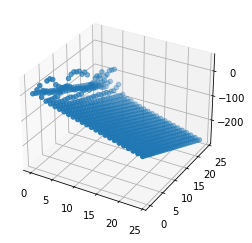

89.76796849333059
[2 3]


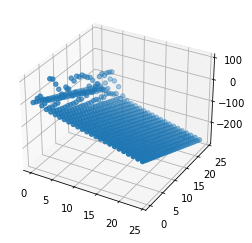

102.5969621031133
[2 4]


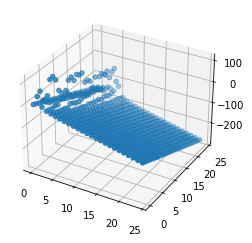

118.27180695553298
[2 3]


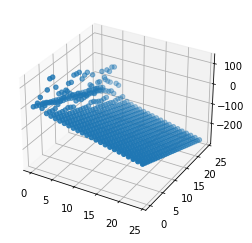

136.66147810734503
[2 3]


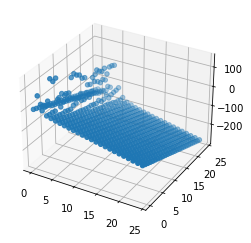

166.65303025607113
[2 3]


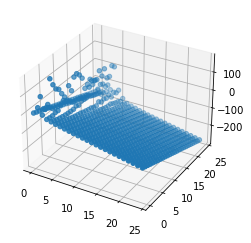

55.32139805698846
[5 2]


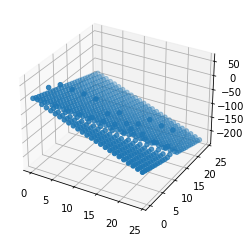

51.359497066572835
[5 2]


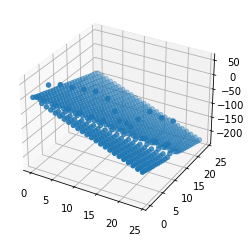

80.47751589031036
[5 2]


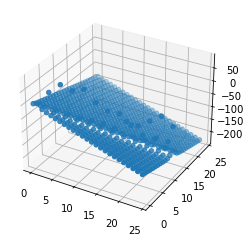

104.39133153063385
[5 2]


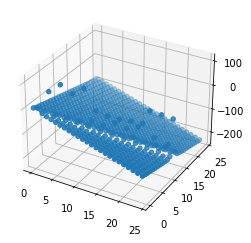

133.55862806913527
[5 2]


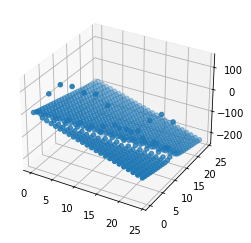

161.02470669826158
[5 2]


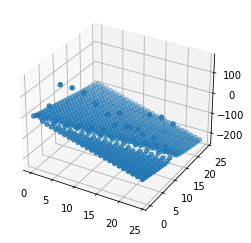

In [42]:
import matplotlib.pyplot as plt
from matplotlib import cm

for ix in range(6):
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Make data.
    X = np.array(simulations0)[625*ix:625*(ix+1),0]
    Y = np.array(simulations0)[625*ix:625*(ix+1),1]
    Z = np.array(utilities0)[625*ix:625*(ix+1)]
    print(Z[np.argmax(Z)])
    print(np.array(simulations0)[625*ix:625*(ix+1),:][np.argmax(Z)])
    ax.scatter(X, Y, Z)
    plt.show()
    
for ix in range(6):
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Make data.
    X = np.array(simulations1)[625*ix:625*(ix+1),0]
    Y = np.array(simulations1)[625*ix:625*(ix+1),1]
    Z = np.array(utilities1)[625*ix:625*(ix+1)]
    print(Z[np.argmax(Z)])
    print(np.array(simulations1)[625*ix:625*(ix+1),:][np.argmax(Z)])
    ax.scatter(X, Y, Z)
    plt.show()

In [45]:
utilities0[np.argmax(utilities0)]

166.65303025607113

In [57]:
utilities1[np.argmax(utilities1)]

161.02470669826158

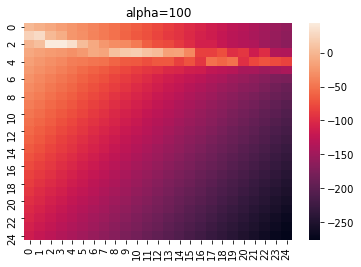

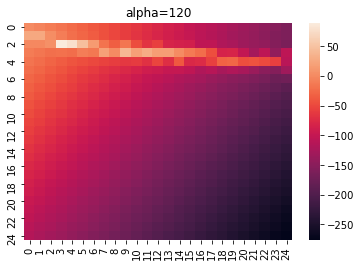

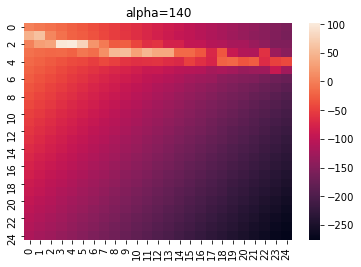

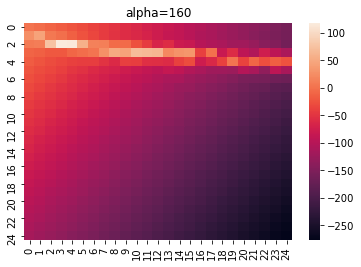

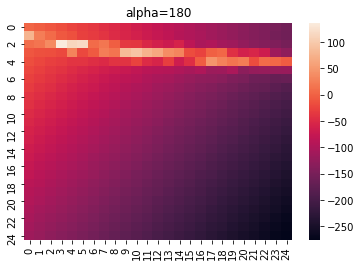

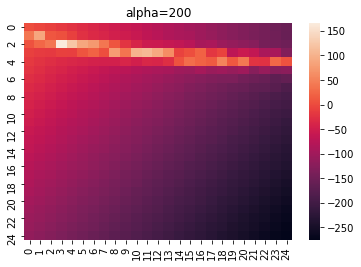

In [64]:
alphas = [100,120,140,160,180,200]
for i in range(6):
    simulations = np.array(simulations0).reshape(6,25*25,2)[i]
    utilities = np.array(utilities0).reshape((6,25*25))[i]
    utilityHeatMap = np.zeros((25,25))
    for ix, (j,k) in enumerate(simulations):
        utilityHeatMap[j,k] = utilities[ix]
    df = pd.DataFrame(data=utilityHeatMap, columns=np.arange(0,25))
    ax = sns.heatmap(df)
    plt.title('alpha=' + str(alphas[i]))
    plt.show()

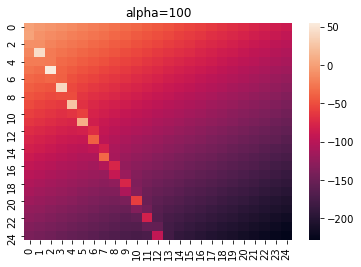

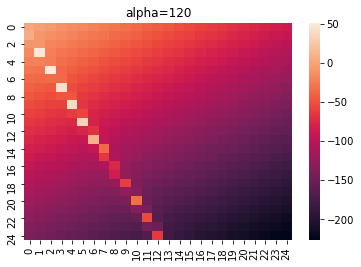

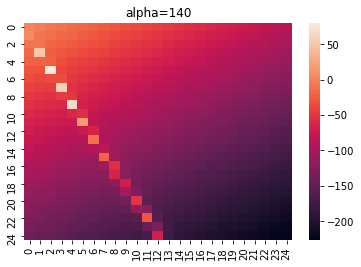

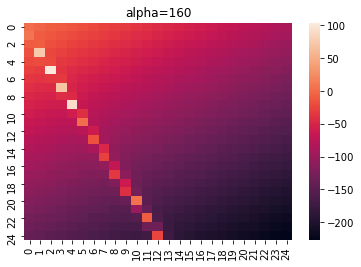

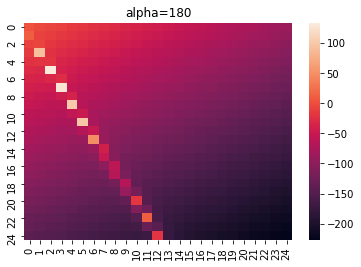

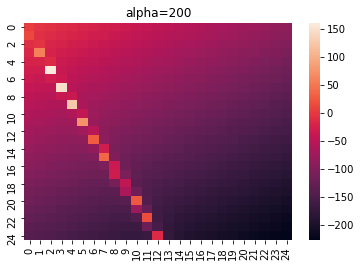

In [65]:
for i in range(6):
    simulations = np.array(simulations1).reshape(6,25*25,2)[i]
    utilities = np.array(utilities1).reshape((6,25*25))[i]
    utilityHeatMap = np.zeros((25,25))
    for ix, (j,k) in enumerate(simulations):
        utilityHeatMap[j,k] = utilities[ix]
    df = pd.DataFrame(data=utilityHeatMap, columns=np.arange(0,25))
    ax = sns.heatmap(df)
    plt.title('alpha=' + str(alphas[i]))
    plt.show()

In [66]:
utilities1_large, simulations1_large = run_tests([100,200,300,400,500,600], 1);

1 0
1 5
1 10
1 15
1 20
1 0
1 5
1 10
1 15
1 20
1 0
1 5
1 10
1 15
1 20
1 0
1 5
1 10
1 15
1 20
1 0
1 5
1 10
1 15
1 20
1 0
1 5
1 10
1 15
1 20


45.76596271847626
[3 1]


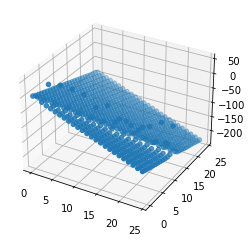

162.59932677149862
[5 2]


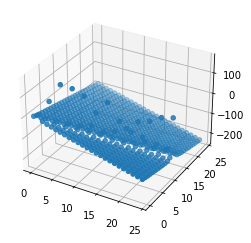

246.71939710990594
[7 3]


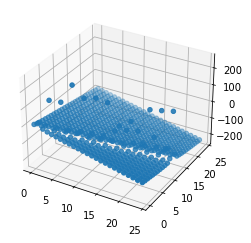

332.72735728632824
[9 4]


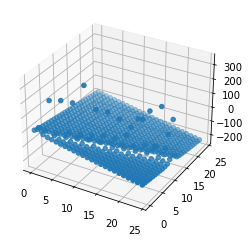

440.69175322544055
[7 3]


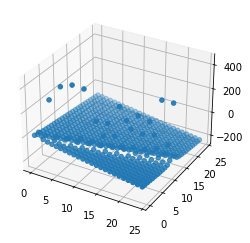

548.861969874528
[5 2]


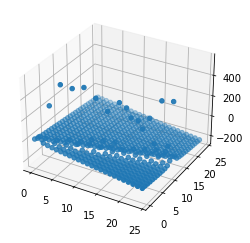

In [67]:
for ix in range(6):
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Make data.
    X = np.array(simulations1_large)[625*ix:625*(ix+1),0]
    Y = np.array(simulations1_large)[625*ix:625*(ix+1),1]
    Z = np.array(utilities1_large)[625*ix:625*(ix+1)]
    print(Z[np.argmax(Z)])
    print(np.array(simulations1_large)[625*ix:625*(ix+1),:][np.argmax(Z)])
    ax.scatter(X, Y, Z)
    plt.show()

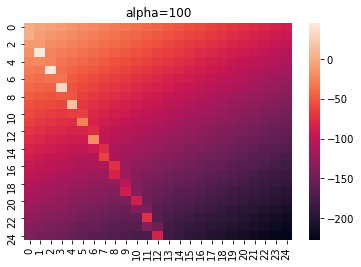

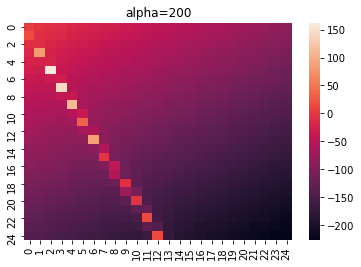

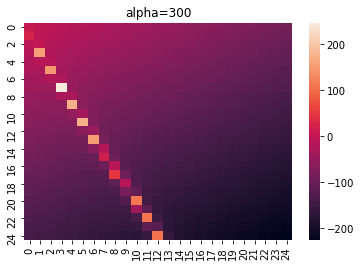

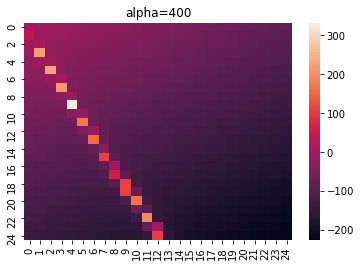

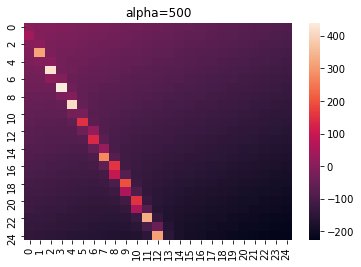

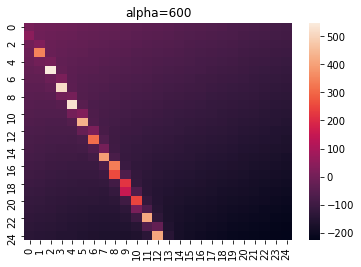

In [69]:
alphas2 = [100,200,300,400,500,600]
for i in range(6):
    simulations = np.array(simulations1_large).reshape(6,25*25,2)[i]
    utilities = np.array(utilities1_large).reshape((6,25*25))[i]
    utilityHeatMap = np.zeros((25,25))
    for ix, (j,k) in enumerate(simulations):
        utilityHeatMap[j,k] = utilities[ix]
    df = pd.DataFrame(data=utilityHeatMap, columns=np.arange(0,25))
    ax = sns.heatmap(df)
    plt.title('alpha=' + str(alphas2[i]))
    plt.show()

In [70]:
utilities1_nocost, simulations1_nocost = run_tests([100,200], 0);
utilities1_noreward, simulations1_noreward = run_tests([0], 1);

1 0
1 5
1 10
1 15
1 20
1 0
1 5
1 10
1 15
1 20
1 0
1 5
1 10
1 15
1 20


69.23483418086856
[2 3]


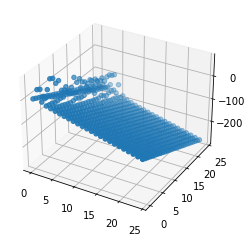

164.376894434747
[2 3]


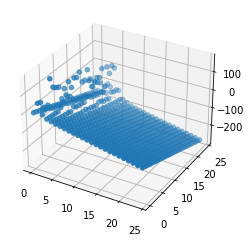

In [73]:
for ix in range(2):
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Make data.
    X = np.array(simulations1_nocost)[625*ix:625*(ix+1),0]
    Y = np.array(simulations1_nocost)[625*ix:625*(ix+1),1]
    Z = np.array(utilities1_nocost)[625*ix:625*(ix+1)]
    print(Z[np.argmax(Z)])
    print(np.array(simulations1_nocost)[625*ix:625*(ix+1),:][np.argmax(Z)])
    ax.scatter(X, Y, Z)
    plt.show()

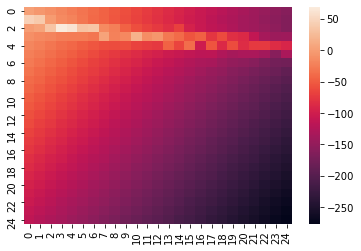

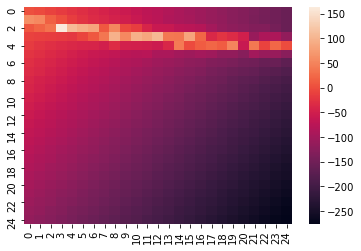

In [83]:
for i in range(2):
    simulations = np.array(simulations1_nocost).reshape(2,25*25,2)[i]
    utilities = np.array(utilities1_nocost).reshape((2,25*25))[i]
    utilityHeatMap = np.zeros((25,25))
    for ix, (j,k) in enumerate(simulations):
        utilityHeatMap[j,k] = utilities[ix]
    df = pd.DataFrame(data=utilityHeatMap, columns=np.arange(0,25))
    ax = sns.heatmap(df)
    plt.show()

0.0
[0 0]


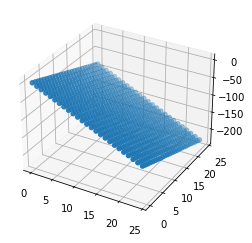

In [77]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.array(simulations1_noreward)[:,0]
Y = np.array(simulations1_noreward)[:,1]
Z = np.array(utilities1_noreward)
print(Z[np.argmax(Z)])
print(np.array(simulations1_noreward)[:,:][np.argmax(Z)])
ax.scatter(X, Y, Z)
plt.show()

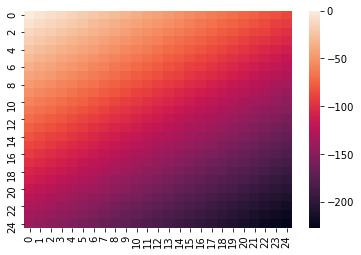

In [80]:
simulations = np.array(simulations1_noreward).reshape(1,25*25,2)[0]
utilities = np.array(utilities1_noreward).reshape((1,25*25))[0]
utilityHeatMap = np.zeros((25,25))
for ix, (j,k) in enumerate(simulations):
    utilityHeatMap[j,k] = utilities[ix]
df = pd.DataFrame(data=utilityHeatMap, columns=np.arange(0,25))
ax = sns.heatmap(df)
plt.show()